In [164]:
import numpy as np 
import pandas as pd 
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

<script type="text/javascript">window.PlotlyConfig = {MathJaxConfig: 'local'};</script><script type="text/javascript">if (window.MathJax) {MathJax.Hub.Config({SVG: {font: "STIX-Web"}});}</script><script>requirejs.config({paths: { 'plotly': ['https://cdn.plot.ly/plotly-latest.min']},});if(!window._Plotly) {require(['plotly'],function(plotly) {window._Plotly=plotly;});}</script>

In [165]:
train = pd.read_csv('./jinnan_round1_train_20181227.csv', encoding = 'gb18030')
test  = pd.read_csv('./jinnan_round1_testA_20181227.csv', encoding = 'gb18030')

In [166]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,96.991404,96.991404,float64
7,A7,75,89.326648,89.326648,object
8,A8,8,89.326648,89.326648,float64
39,B11,37,60.816619,60.816619,object
38,B10,180,17.478510,17.478510,object
3,A3,3,3.008596,95.702006,float64
29,B1,21,0.716332,53.796562,float64
23,A23,3,0.214900,99.641834,float64
21,A21,12,0.214900,89.828080,float64
30,B2,3,0.143266,98.424069,float64


In [167]:
stats = []
for col in test.columns:
    stats.append((col, test[col].nunique(), test[col].isnull().sum() * 100 / test.shape[0], test[col].value_counts(normalize=True, dropna=False).values[0] * 100, test[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False)[:10]

,Feature,Unique_values,Percentage of missing values,Percentage of values in the biggest category,type
2,A2,1,98.000000,98.000000,float64
7,A7,15,88.000000,88.000000,object
8,A8,2,88.000000,88.000000,float64
39,B11,11,59.333333,59.333333,object
38,B10,50,14.666667,14.666667,object
3,A3,2,2.000000,97.333333,float64
25,A25,7,0.666667,42.000000,float64
27,A27,11,0.666667,47.333333,float64
20,A20,52,0.666667,20.000000,object
29,B1,13,0.666667,56.000000,float64


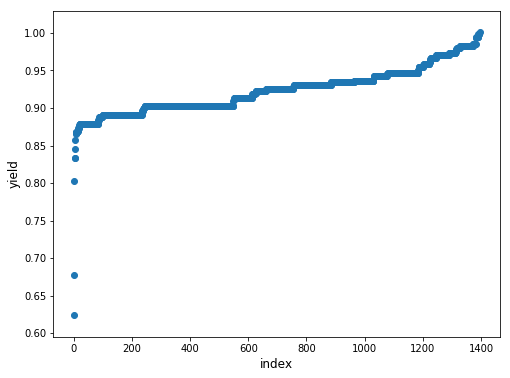

In [168]:
target_col = "收率"

plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train[target_col].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

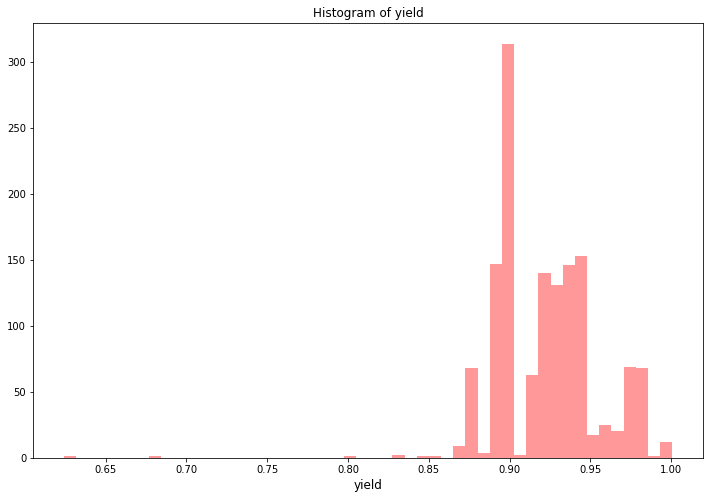

In [169]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col].values, bins=50, kde=False, color="red")
plt.title("Histogram of yield")
plt.xlabel('yield', fontsize=12)
plt.show()

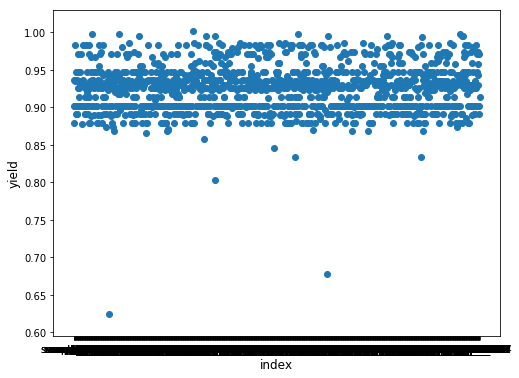

In [171]:
#train['样本id'] = train['样本id'].map(lambda x:x.split('_')[1])
plt.figure(figsize=(8,6))
plt.scatter(train['样本id'], train[target_col])
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()

In [172]:
"""
tmp = train[train[target_col]>0.92]
tmp['样本id']
plt.figure(figsize=(8,16))
plt.scatter(tmp['样本id'], tmp[target_col])
plt.xlabel('index', fontsize=12)
plt.ylabel('yield', fontsize=12)
plt.show()
train.to_csv('chakan.csv',encoding='gbk')
tmp = pd.DataFrame(np.zeros(2000))
tmp = tmp.reset_index()
tmp['index'] = tmp['index'] +1
tmp = tmp.merge(train[train[target_col]<=0.902],left_on='index' ,right_on= '样本id',how='left')
tmp.to_csv('aaa902.csv',encoding='gbk')
tmp = pd.DataFrame(np.zeros(2000))
tmp = tmp.reset_index()
tmp['index'] = tmp['index'] +1
tmp = tmp.merge(train[train[target_col]>0.902],left_on='index' ,right_on= '样本id',how='left')
tmp.to_csv('aaadayu902.csv',encoding='gbk')
num = 560
print(train.loc[865,target_col])

train['target_feature'] = mean_num
train['target_feature']
for num in range(500,600):
    pre_d_all = []
    for id in train[train[target_col]>0.92]['样本id'].values:
        sum_all = 0
        num_j = 0
        for i in [-3,-2,-1,1,2,3]:
            if (id + i * num) in train['样本id'].values:
                num_j+=1
                sum_all +=train.loc[train['样本id'] == id + i * num,target_col].values
        if num_j == 0:
            pre_d = mean_num
        else:
            pre_d = (sum_all/num_j)[0]
        pre_d_all.append([id,pre_d])
    pre_d_all = pd.DataFrame(pre_d_all)
    pre_d_all.columns =['id','pred']
    pre_d_all = pre_d_all.merge(train[['样本id',target_col]],left_on= 'id',right_on = '样本id',how='left')
    pre_d_all['mean'] = np.mean(pre_d_all[target_col])
    pre_d_all

    print('============================',num)
    print(mean_squared_error(pre_d_all[target_col],pre_d_all['pred']))
    print(mean_squared_error(pre_d_all[target_col],pre_d_all['mean']))
    pre_d_all
train[train[target_col]>0.92]['样本id']
pre_d_all = pd.DataFrame(pre_d_all)
pre_d_all[target_col] = train[target_col]
pre_d_all['mean'] = np.mean(pre_d_all[target_col])
pre_d_all
pre_d_all.columns =['id','pred' , '收率', 'mean']
print(mean_squared_error(pre_d_all[target_col],pre_d_all['pred']))
print(mean_squared_error(pre_d_all[target_col],pre_d_all['mean']))"""

"\ntmp = train[train[target_col]>0.92]\ntmp['样本id']\nplt.figure(figsize=(8,16))\nplt.scatter(tmp['样本id'], tmp[target_col])\nplt.xlabel('index', fontsize=12)\nplt.ylabel('yield', fontsize=12)\nplt.show()\ntrain.to_csv('chakan.csv',encoding='gbk')\ntmp = pd.DataFrame(np.zeros(2000))\ntmp = tmp.reset_index()\ntmp['index'] = tmp['index'] +1\ntmp = tmp.merge(train[train[target_col]<=0.902],left_on='index' ,right_on= '样本id',how='left')\ntmp.to_csv('aaa902.csv',encoding='gbk')\ntmp = pd.DataFrame(np.zeros(2000))\ntmp = tmp.reset_index()\ntmp['index'] = tmp['index'] +1\ntmp = tmp.merge(train[train[target_col]>0.902],left_on='index' ,right_on= '样本id',how='left')\ntmp.to_csv('aaadayu902.csv',encoding='gbk')\nnum = 560\nprint(train.loc[865,target_col])\n\ntrain['target_feature'] = mean_num\ntrain['target_feature']\nfor num in range(500,600):\n    pre_d_all = []\n    for id in train[train[target_col]>0.92]['样本id'].values:\n        sum_all = 0\n        num_j = 0\n        for i in [-3,-2,-1,1,2,3]:\

In [173]:
# 删除类别唯一的特征
for df in [train, test]:
    df.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)

In [174]:
# 删除某一类别占比超过90%的列
good_cols = list(train.columns)
for col in train.columns:
    rate = train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        good_cols.remove(col)
        print(col,rate)

# 暂时不删除，后面构造特征需要
good_cols.append('A1')
good_cols.append('A3')
good_cols.append('A4')

# 删除异常值
train = train[train['收率']>0.87]
        
train = train[good_cols]
good_cols.remove('收率')
test  = test[good_cols]

A1 0.9863896848137536
A2 0.9699140401146131
A3 0.9570200573065902
A4 0.9570200573065902
B2 0.9842406876790831


In [175]:
# 合并数据集
target = train['收率']
del train['收率']
data = pd.concat([train,test],axis=0,ignore_index=True)
data = data.fillna(-1)

In [176]:
def timeTranSecond(t):
    try:
        t,m,s=t.split(":")
    except:
        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif t==-1:
            return -1
        else:
            return 0
    
    try:
        tm = (int(t)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600
    
    return tm
for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
    try:
        data[f] = data[f].apply(timeTranSecond)
    except:
        print(f,'应该在前面被删除了！')

def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+\.?\d*",se)
    except:
        if se == -1:
            return -1 
        
    try:
        if int(sh)>int(eh):
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600 + 24
        else:
            tm = (int(eh)*3600+int(em)*60-int(sm)*60-int(sh)*3600)/3600
    except:
        if se=='19:-20:05':
            return 1
        elif se=='15:00-1600':
            return 1
    
    return tm
for f in ['A20','A28','B4','B9','B10','B11']:
    data[f] = data.apply(lambda df: getDuration(df[f]), axis=1)

In [177]:
data['样本id'] = data['样本id'].apply(lambda x: int(x.split('_')[1]))

categorical_columns = [f for f in data.columns if f not in ['样本id']]
numerical_columns = [f for f in data.columns if f not in categorical_columns]

In [178]:
# 有风的冬老哥，在群里无意爆出来的特征，让我提升了三个个点，当然也可以顺此继续扩展
data['b14/a1_a3_a4_a19_b1_b12'] = data['B14']/(data['A1']+data['A3']+data['A4']+data['A19']+data['B1']+data['B12'])

numerical_columns.append('b14/a1_a3_a4_a19_b1_b12')

del data['A1']
del data['A3']
del data['A4']
categorical_columns.remove('A1')
categorical_columns.remove('A3')
categorical_columns.remove('A4')

In [179]:
#label encoder
for f in categorical_columns:
    data[f] = data[f].map(dict(zip(data[f].unique(), range(0, data[f].nunique()))))
train = data[:train.shape[0]]
test  = data[train.shape[0]:]
print(train.shape)
print(test.shape)

(1381, 34)
(150, 34)


In [180]:
#train['target'] = list(target) 
train['target'] = target
train['intTarget'] = pd.cut(train['target'], 5, labels=False)
train = pd.get_dummies(train, columns=['intTarget'])
li = ['intTarget_0.0','intTarget_1.0','intTarget_2.0','intTarget_3.0','intTarget_4.0']
mean_columns = []
for f1 in categorical_columns:
    cate_rate = train[f1].value_counts(normalize=True, dropna=False).values[0]
    if cate_rate < 0.90:
        for f2 in li:
            col_name = 'B14_to_'+f1+"_"+f2+'_mean'
            mean_columns.append(col_name)
            order_label = train.groupby([f1])[f2].mean()
            train[col_name] = train['B14'].map(order_label)
            miss_rate = train[col_name].isnull().sum() * 100 / train[col_name].shape[0]
            if miss_rate > 0:
                train = train.drop([col_name], axis=1)
                mean_columns.remove(col_name)
            else:
                test[col_name] = test['B14'].map(order_label)
                
train.drop(li+['target'], axis=1, inplace=True)
print(train.shape)
print(test.shape)

(1381, 109)
(150, 109)


In [181]:
X_train = train[mean_columns+numerical_columns].values
X_test = test[mean_columns+numerical_columns].values
# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

(1381, 1246)
(150, 1246)


In [193]:
train.columns
print(len(mean_columns))
print(len(numerical_columns))

75
2


In [182]:
y_train = target.values

In [183]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000193562	valid_1's l2: 0.000211955
[400]	training's l2: 0.000127595	valid_1's l2: 0.000145901


[600]	training's l2: 0.000109162	valid_1's l2: 0.000128985
[800]	training's l2: 0.000101148	valid_1's l2: 0.000123493


[1000]	training's l2: 9.63139e-05	valid_1's l2: 0.000120602


[1200]	training's l2: 9.32305e-05	valid_1's l2: 0.000119063
[1400]	training's l2: 9.08085e-05	valid_1's l2: 0.000118055
[1600]	training's l2: 8.88322e-05	valid_1's l2: 0.000117276


[1800]	training's l2: 8.73339e-05	valid_1's l2: 0.000116686
[2000]	training's l2: 8.60319e-05	valid_1's l2: 0.000116306
[2200]	training's l2: 8.49564e-05	valid_1's l2: 0.00011604
[2400]	training's l2: 8.39673e-05	valid_1's l2: 0.000115488


[2600]	training's l2: 8.3056e-05	valid_1's l2: 0.000115247
[2800]	training's l2: 8.24558e-05	valid_1's l2: 0.000115062
Early stopping, best iteration is:
[2736]	training's l2: 8.24558e-05	valid_1's l2: 0.000115062


fold n°2
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000188177	valid_1's l2: 0.000207844


[400]	training's l2: 0.000122487	valid_1's l2: 0.000159511
[600]	training's l2: 0.000105057	valid_1's l2: 0.000149253
[800]	training's l2: 9.72443e-05	valid_1's l2: 0.00014575


[1000]	training's l2: 9.24182e-05	valid_1's l2: 0.000143559
[1200]	training's l2: 8.92134e-05	valid_1's l2: 0.000141962
[1400]	training's l2: 8.68323e-05	valid_1's l2: 0.000140743


[1600]	training's l2: 8.50641e-05	valid_1's l2: 0.000139953
[1800]	training's l2: 8.35839e-05	valid_1's l2: 0.000139607
Early stopping, best iteration is:
[1843]	training's l2: 8.33208e-05	valid_1's l2: 0.000139517


fold n°3
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000183775	valid_1's l2: 0.000228847
[400]	training's l2: 0.000122008	valid_1's l2: 0.000164526


[600]	training's l2: 0.000103856	valid_1's l2: 0.000147236
[800]	training's l2: 9.60211e-05	valid_1's l2: 0.000141159
[1000]	training's l2: 9.16083e-05	valid_1's l2: 0.000137965


[1200]	training's l2: 8.85203e-05	valid_1's l2: 0.000136078
[1400]	training's l2: 8.64595e-05	valid_1's l2: 0.000134876
[1600]	training's l2: 8.4816e-05	valid_1's l2: 0.00013407


[1800]	training's l2: 8.34496e-05	valid_1's l2: 0.000133327
[2000]	training's l2: 8.22876e-05	valid_1's l2: 0.000132661
Early stopping, best iteration is:
[2044]	training's l2: 8.20235e-05	valid_1's l2: 0.000132503


fold n°4
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000190982	valid_1's l2: 0.000207999
[400]	training's l2: 0.00012847	valid_1's l2: 0.000157359


[600]	training's l2: 0.000109944	valid_1's l2: 0.000141289
[800]	training's l2: 0.000102042	valid_1's l2: 0.000135283


[1000]	training's l2: 9.72202e-05	valid_1's l2: 0.000131987
[1200]	training's l2: 9.37261e-05	valid_1's l2: 0.000129647
[1400]	training's l2: 9.12316e-05	valid_1's l2: 0.000128145
[1600]	training's l2: 8.89994e-05	valid_1's l2: 0.000127156


[1800]	training's l2: 8.73206e-05	valid_1's l2: 0.000126362
[2000]	training's l2: 8.59058e-05	valid_1's l2: 0.000125854
Early stopping, best iteration is:
[1965]	training's l2: 8.60603e-05	valid_1's l2: 0.000125797


fold n°5
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000192318	valid_1's l2: 0.00019332
[400]	training's l2: 0.000129691	valid_1's l2: 0.000127878


[600]	training's l2: 0.000112029	valid_1's l2: 0.000112855
[800]	training's l2: 0.000103826	valid_1's l2: 0.000107591
[1000]	training's l2: 9.8779e-05	valid_1's l2: 0.000104754


[1200]	training's l2: 9.51962e-05	valid_1's l2: 0.000103333
[1400]	training's l2: 9.25215e-05	valid_1's l2: 0.000102454


[1600]	training's l2: 9.03429e-05	valid_1's l2: 0.000101645
[1800]	training's l2: 8.85518e-05	valid_1's l2: 0.00010119
Early stopping, best iteration is:
[1849]	training's l2: 8.81448e-05	valid_1's l2: 0.000101033


CV score: 0.00012278


In [184]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.422932	valid_data-rmse:0.423819


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257007	valid_data-rmse:0.257742


[200]	train-rmse:0.156628	valid_data-rmse:0.157354


[300]	train-rmse:0.095903	valid_data-rmse:0.096731


[400]	train-rmse:0.0593	valid_data-rmse:0.060161


[500]	train-rmse:0.037281	valid_data-rmse:0.038261


[600]	train-rmse:0.024073	valid_data-rmse:0.025378


[700]	train-rmse:0.016218	valid_data-rmse:0.018097


[800]	train-rmse:0.011605	valid_data-rmse:0.014251


[900]	train-rmse:0.009006	valid_data-rmse:0.012425


[1000]	train-rmse:0.007536	valid_data-rmse:0.011578


[1100]	train-rmse:0.006684	valid_data-rmse:0.011195


[1200]	train-rmse:0.006155	valid_data-rmse:0.011032


[1300]	train-rmse:0.005783	valid_data-rmse:0.010948


[1400]	train-rmse:0.005474	valid_data-rmse:0.010907


[1500]	train-rmse:0.005201	valid_data-rmse:0.010887


[1600]	train-rmse:0.004967	valid_data-rmse:0.010873


[1700]	train-rmse:0.004762	valid_data-rmse:0.010863


[1800]	train-rmse:0.00458	valid_data-rmse:0.010856


[1900]	train-rmse:0.004383	valid_data-rmse:0.010854


[2000]	train-rmse:0.004232	valid_data-rmse:0.010853


[2100]	train-rmse:0.00409	valid_data-rmse:0.010852


[2200]	train-rmse:0.003951	valid_data-rmse:0.010854


Stopping. Best iteration:
[2061]	train-rmse:0.004134	valid_data-rmse:0.010848



fold n°2
[0]	train-rmse:0.424042	valid_data-rmse:0.419362


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257673	valid_data-rmse:0.254133


[200]	train-rmse:0.157021	valid_data-rmse:0.154246


[300]	train-rmse:0.096156	valid_data-rmse:0.093817


[400]	train-rmse:0.059446	valid_data-rmse:0.057652


[500]	train-rmse:0.037303	valid_data-rmse:0.036199


[600]	train-rmse:0.024012	valid_data-rmse:0.023764


[700]	train-rmse:0.016122	valid_data-rmse:0.016988


[800]	train-rmse:0.011489	valid_data-rmse:0.013632


[900]	train-rmse:0.008834	valid_data-rmse:0.012136


[1000]	train-rmse:0.007333	valid_data-rmse:0.011556


[1100]	train-rmse:0.006478	valid_data-rmse:0.011354


[1200]	train-rmse:0.005938	valid_data-rmse:0.011315


[1300]	train-rmse:0.005572	valid_data-rmse:0.011321


[1400]	train-rmse:0.005285	valid_data-rmse:0.011343


Stopping. Best iteration:
[1222]	train-rmse:0.005842	valid_data-rmse:0.011311



fold n°3
[0]	train-rmse:0.422401	valid_data-rmse:0.425951


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256678	valid_data-rmse:0.259802


[200]	train-rmse:0.156388	valid_data-rmse:0.159198


[300]	train-rmse:0.095756	valid_data-rmse:0.098402


[400]	train-rmse:0.05921	valid_data-rmse:0.061441


[500]	train-rmse:0.0372	valid_data-rmse:0.039042


[600]	train-rmse:0.023988	valid_data-rmse:0.025762


[700]	train-rmse:0.016104	valid_data-rmse:0.018278


[800]	train-rmse:0.011481	valid_data-rmse:0.014388


[900]	train-rmse:0.008842	valid_data-rmse:0.012598


[1000]	train-rmse:0.007347	valid_data-rmse:0.011841


[1100]	train-rmse:0.006489	valid_data-rmse:0.011563


[1200]	train-rmse:0.005973	valid_data-rmse:0.011468


[1300]	train-rmse:0.005611	valid_data-rmse:0.011444


[1400]	train-rmse:0.005334	valid_data-rmse:0.011448


[1500]	train-rmse:0.005093	valid_data-rmse:0.011463


Stopping. Best iteration:
[1371]	train-rmse:0.00541	valid_data-rmse:0.011441



fold n°4
[0]	train-rmse:0.422949	valid_data-rmse:0.423757


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257011	valid_data-rmse:0.256907


[200]	train-rmse:0.156605	valid_data-rmse:0.155971


[300]	train-rmse:0.095936	valid_data-rmse:0.095252


[400]	train-rmse:0.059328	valid_data-rmse:0.058729


[500]	train-rmse:0.037251	valid_data-rmse:0.03688


[600]	train-rmse:0.02403	valid_data-rmse:0.02416


[700]	train-rmse:0.016166	valid_data-rmse:0.017156


[800]	train-rmse:0.011572	valid_data-rmse:0.013624


[900]	train-rmse:0.008959	valid_data-rmse:0.012038


[1000]	train-rmse:0.007449	valid_data-rmse:0.011378


[1100]	train-rmse:0.006584	valid_data-rmse:0.011133


[1200]	train-rmse:0.006066	valid_data-rmse:0.011044


[1300]	train-rmse:0.00566	valid_data-rmse:0.011018


[1400]	train-rmse:0.005361	valid_data-rmse:0.011022


Stopping. Best iteration:
[1295]	train-rmse:0.005681	valid_data-rmse:0.011018



fold n°5
[0]	train-rmse:0.423228	valid_data-rmse:0.422635


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.25717	valid_data-rmse:0.256872


[200]	train-rmse:0.156714	valid_data-rmse:0.156539


[300]	train-rmse:0.096014	valid_data-rmse:0.095774


[400]	train-rmse:0.059389	valid_data-rmse:0.059276


[500]	train-rmse:0.037363	valid_data-rmse:0.037549


[600]	train-rmse:0.024128	valid_data-rmse:0.024696


[700]	train-rmse:0.01629	valid_data-rmse:0.017396


[800]	train-rmse:0.011722	valid_data-rmse:0.013521


[900]	train-rmse:0.009108	valid_data-rmse:0.011614


[1000]	train-rmse:0.007601	valid_data-rmse:0.010725


[1100]	train-rmse:0.006738	valid_data-rmse:0.010324


[1200]	train-rmse:0.006213	valid_data-rmse:0.010161


[1300]	train-rmse:0.005837	valid_data-rmse:0.010092


[1400]	train-rmse:0.005538	valid_data-rmse:0.010067


[1500]	train-rmse:0.005258	valid_data-rmse:0.010057


[1600]	train-rmse:0.005039	valid_data-rmse:0.010065


[1700]	train-rmse:0.004813	valid_data-rmse:0.010071


Stopping. Best iteration:
[1503]	train-rmse:0.005249	valid_data-rmse:0.010055



CV score: 0.00011980


In [185]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_squared_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.00011593110970965297

In [186]:
sub_df = pd.read_csv('./jinnan_round1_submit_20181227.csv', header=None)
sub_df[1] = predictions
sub_df[1] = sub_df[1].apply(lambda x:round(x, 3))

In [187]:
def modeling_cross_validation(params, X, y, nr_folds=5):
    
    oof_preds = np.zeros(X.shape[0])
    # Split data with kfold
    folds = KFold(n_splits=nr_folds, shuffle=False, random_state=4096)
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print("fold n°{}".format(fold_+1))
        trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
        val_data = lgb.Dataset(X[val_idx], y[val_idx])

        num_round = 20000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 100)
        oof_preds[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)

    score = mean_squared_error(oof_preds, target)
    
    return  score/2

In [190]:
def featureSelect(init_cols):
    params = {'num_leaves': 120,
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.05,
             "min_child_samples": 30,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'mse',
             "lambda_l1": 0.02,
             "verbosity": -1}
    best_cols = init_cols.copy()
    best_score = modeling_cross_validation(params, train[init_cols].values, target.values, nr_folds=5)
    print("初始CV score: {:<8.8f}".format(best_score))
    for f in init_cols:

        best_cols.remove(f)
        score = modeling_cross_validation(params, train[best_cols].values, target.values, nr_folds=5)
        diff = best_score - score
        print('-'*10)
        if diff > 0.00000002:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 有效果,删除！！".format(f,score,best_score))
            best_score = score
        else:
            print("当前移除特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}, 没效果,保留！！".format(f,score,best_score))
            best_cols.append(f)
    print('-'*10)
    print("优化后CV score: {:<8.8f}".format(best_score))
    
    return best_cols
    
best_features = featureSelect(train.columns.tolist())

fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 5.40003e-05	valid_1's l2: 0.000144782
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[199]	training's l2: 5.22154e-05	valid_1's l2: 0.000134531
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[371]	training's l2: 4.09579e-05	valid_1's l2: 0.000123256
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[172]	training's l2: 6.3404e-05	valid_1's l2: 0.000113259
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[189]	training's l2: 5.63576e-05	valid_1's l2: 0.000145067
初始CV score: 0.00006609
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[156]	training's l2: 0.000107784	valid_1's l2: 0.000188472
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 0.000105921	valid_1's l2: 0.000218893
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[237]	training's l2: 0.000100045	valid_1's l2: 0.00016032
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[135]	training's l2: 0.000122662	valid_1's l2: 0.000143453
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[232]	training's l2: 9.80047e-05	valid_1's l2: 0.000183783


----------
当前移除特征: 样本id, CV score: 0.00008950, 最佳cv score: 0.00006609, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[134]	training's l2: 6.68623e-05	valid_1's l2: 0.000146986
fold n°2
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[227]	training's l2: 5.03729e-05	valid_1's l2: 0.000135757
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[342]	training's l2: 4.40595e-05	valid_1's l2: 0.00012276
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[138]	training's l2: 7.19427e-05	valid_1's l2: 0.000114633
fold n°5
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[179]	training's l2: 5.92492e-05	valid_1's l2: 0.000144002
----------
当前移除特征: A5, CV score: 0.00006642, 最佳cv score: 0.00006609, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[228]	training's l2: 5.05199e-05	valid_1's l2: 0.000146298
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[236]	training's l2: 4.96473e-05	valid_1's l2: 0.000138225
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[288]	training's l2: 5.00245e-05	valid_1's l2: 0.000116618
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[194]	training's l2: 6.09497e-05	valid_1's l2: 0.000108464


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[246]	training's l2: 4.98714e-05	valid_1's l2: 0.000145543
----------
当前移除特征: A6, CV score: 0.00006552, 最佳cv score: 0.00006609, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[177]	training's l2: 5.75361e-05	valid_1's l2: 0.000148163


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[212]	training's l2: 5.2302e-05	valid_1's l2: 0.000136787
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[309]	training's l2: 4.86592e-05	valid_1's l2: 0.000119416
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[169]	training's l2: 6.54308e-05	valid_1's l2: 0.00011035
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[209]	training's l2: 5.4833e-05	valid_1's l2: 0.00014654


----------
当前移除特征: A7, CV score: 0.00006613, 最佳cv score: 0.00006552, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 5.02659e-05	valid_1's l2: 0.000145821
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[219]	training's l2: 5.07417e-05	valid_1's l2: 0.000134234


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 5.02393e-05	valid_1's l2: 0.000116053
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[165]	training's l2: 6.569e-05	valid_1's l2: 0.000109976
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[235]	training's l2: 5.11975e-05	valid_1's l2: 0.000143777


----------
当前移除特征: A8, CV score: 0.00006499, 最佳cv score: 0.00006552, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 6.59556e-05	valid_1's l2: 0.000147816
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[176]	training's l2: 5.82605e-05	valid_1's l2: 0.000135189


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[238]	training's l2: 5.60935e-05	valid_1's l2: 0.000118368
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[168]	training's l2: 6.54692e-05	valid_1's l2: 0.000112061
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[145]	training's l2: 6.67478e-05	valid_1's l2: 0.00014568
----------
当前移除特征: A9, CV score: 0.00006592, 最佳cv score: 0.00006499, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[228]	training's l2: 5.149e-05	valid_1's l2: 0.00014911
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[157]	training's l2: 6.32244e-05	valid_1's l2: 0.00013573


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[367]	training's l2: 4.50412e-05	valid_1's l2: 0.000120777
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[218]	training's l2: 5.81589e-05	valid_1's l2: 0.0001124


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[268]	training's l2: 5.02385e-05	valid_1's l2: 0.000144064
----------
当前移除特征: A10, CV score: 0.00006621, 最佳cv score: 0.00006499, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[289]	training's l2: 4.43742e-05	valid_1's l2: 0.000145313
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[221]	training's l2: 5.10943e-05	valid_1's l2: 0.000139343
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[229]	training's l2: 5.76604e-05	valid_1's l2: 0.000116031


fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[172]	training's l2: 6.49486e-05	valid_1's l2: 0.000110101
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[261]	training's l2: 4.86298e-05	valid_1's l2: 0.000145357
----------
当前移除特征: A11, CV score: 0.00006562, 最佳cv score: 0.00006499, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[337]	training's l2: 4.14532e-05	valid_1's l2: 0.000147827
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[234]	training's l2: 4.91653e-05	valid_1's l2: 0.000135711
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[370]	training's l2: 4.41332e-05	valid_1's l2: 0.000118241
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[161]	training's l2: 6.66409e-05	valid_1's l2: 0.000110674
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[223]	training's l2: 5.32895e-05	valid_1's l2: 0.000143376


----------
当前移除特征: A12, CV score: 0.00006559, 最佳cv score: 0.00006499, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[145]	training's l2: 6.43413e-05	valid_1's l2: 0.000148151
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[177]	training's l2: 5.81789e-05	valid_1's l2: 0.00013701
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[302]	training's l2: 4.87132e-05	valid_1's l2: 0.000117951
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[162]	training's l2: 6.65333e-05	valid_1's l2: 0.000112411
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[187]	training's l2: 5.81003e-05	valid_1's l2: 0.000147528


----------
当前移除特征: A14, CV score: 0.00006631, 最佳cv score: 0.00006499, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[181]	training's l2: 5.79326e-05	valid_1's l2: 0.000146246


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[185]	training's l2: 5.67318e-05	valid_1's l2: 0.000135297


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[237]	training's l2: 5.62907e-05	valid_1's l2: 0.000116973
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[218]	training's l2: 5.73036e-05	valid_1's l2: 0.000109291


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[202]	training's l2: 5.62027e-05	valid_1's l2: 0.000143943
----------
当前移除特征: A15, CV score: 0.00006518, 最佳cv score: 0.00006499, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[193]	training's l2: 5.50534e-05	valid_1's l2: 0.000147237


fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[230]	training's l2: 4.93254e-05	valid_1's l2: 0.00013809
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[288]	training's l2: 5.02223e-05	valid_1's l2: 0.00011748
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[141]	training's l2: 7.29932e-05	valid_1's l2: 0.000108897
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[235]	training's l2: 5.13667e-05	valid_1's l2: 0.000146008
----------
当前移除特征: A16, CV score: 0.00006578, 最佳cv score: 0.00006499, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[193]	training's l2: 5.55028e-05	valid_1's l2: 0.000147514


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[214]	training's l2: 5.21365e-05	valid_1's l2: 0.00013647


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[295]	training's l2: 5.05401e-05	valid_1's l2: 0.000113879
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[183]	training's l2: 6.2461e-05	valid_1's l2: 0.000109396


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[329]	training's l2: 4.39341e-05	valid_1's l2: 0.000141046
----------
当前移除特征: A17, CV score: 0.00006484, 最佳cv score: 0.00006499, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[229]	training's l2: 5.04551e-05	valid_1's l2: 0.00014749
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[248]	training's l2: 4.8296e-05	valid_1's l2: 0.000138142


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[254]	training's l2: 5.46532e-05	valid_1's l2: 0.000113562
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 6.19814e-05	valid_1's l2: 0.000109034
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[238]	training's l2: 5.19829e-05	valid_1's l2: 0.000142294
----------
当前移除特征: A19, CV score: 0.00006506, 最佳cv score: 0.00006484, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[159]	training's l2: 6.20229e-05	valid_1's l2: 0.000146444
fold n°2
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[251]	training's l2: 4.80969e-05	valid_1's l2: 0.000137211
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[284]	training's l2: 5.1444e-05	valid_1's l2: 0.000117318
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[164]	training's l2: 6.70219e-05	valid_1's l2: 0.000112719
fold n°5
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[259]	training's l2: 5.01427e-05	valid_1's l2: 0.000140578
----------
当前移除特征: A20, CV score: 0.00006543, 最佳cv score: 0.00006484, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[201]	training's l2: 5.45081e-05	valid_1's l2: 0.000147369


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[177]	training's l2: 5.89886e-05	valid_1's l2: 0.000135974
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 5.08011e-05	valid_1's l2: 0.000117538
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[169]	training's l2: 6.60958e-05	valid_1's l2: 0.000109377
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[275]	training's l2: 4.8112e-05	valid_1's l2: 0.000143014
----------
当前移除特征: A21, CV score: 0.00006533, 最佳cv score: 0.00006484, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[201]	training's l2: 5.47425e-05	valid_1's l2: 0.0001486
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[174]	training's l2: 5.88951e-05	valid_1's l2: 0.000137942
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[351]	training's l2: 4.5354e-05	valid_1's l2: 0.000116768
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[230]	training's l2: 5.56022e-05	valid_1's l2: 0.000106924
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[201]	training's l2: 5.69187e-05	valid_1's l2: 0.00014642
----------
当前移除特征: A22, CV score: 0.00006567, 最佳cv score: 0.00006484, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[310]	training's l2: 4.29675e-05	valid_1's l2: 0.000142056
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[184]	training's l2: 5.71901e-05	valid_1's l2: 0.000135751
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[307]	training's l2: 4.9071e-05	valid_1's l2: 0.000114979
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 5.43102e-05	valid_1's l2: 0.000110571
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[175]	training's l2: 6.07671e-05	valid_1's l2: 0.000144463
----------
当前移除特征: A24, CV score: 0.00006479, 最佳cv score: 0.00006484, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[199]	training's l2: 5.68269e-05	valid_1's l2: 0.000137926
fold n°2


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[246]	training's l2: 5.01165e-05	valid_1's l2: 0.000133174
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[288]	training's l2: 5.31594e-05	valid_1's l2: 0.000113629
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[214]	training's l2: 5.90382e-05	valid_1's l2: 0.000110352
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[286]	training's l2: 4.88785e-05	valid_1's l2: 0.000141669
----------
当前移除特征: A25, CV score: 0.00006368, 最佳cv score: 0.00006479, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[139]	training's l2: 6.88528e-05	valid_1's l2: 0.000145512
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[176]	training's l2: 6.17804e-05	valid_1's l2: 0.000132716
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[332]	training's l2: 5.05081e-05	valid_1's l2: 0.00011423
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[186]	training's l2: 6.39766e-05	valid_1's l2: 0.000111093
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[233]	training's l2: 5.56431e-05	valid_1's l2: 0.00013865
----------
当前移除特征: A26, CV score: 0.00006423, 最佳cv score: 0.00006368, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[187]	training's l2: 5.92107e-05	valid_1's l2: 0.000140608


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[215]	training's l2: 5.56543e-05	valid_1's l2: 0.000132159
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[307]	training's l2: 5.21834e-05	valid_1's l2: 0.000111871
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[158]	training's l2: 7.03455e-05	valid_1's l2: 0.000109
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[272]	training's l2: 5.10407e-05	valid_1's l2: 0.000143553
----------
当前移除特征: A27, CV score: 0.00006372, 最佳cv score: 0.00006368, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[191]	training's l2: 5.84062e-05	valid_1's l2: 0.000140745
fold n°2


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 5.12391e-05	valid_1's l2: 0.00013225
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[292]	training's l2: 5.22625e-05	valid_1's l2: 0.000115177
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 5.94608e-05	valid_1's l2: 0.000108553
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[218]	training's l2: 5.58587e-05	valid_1's l2: 0.000143044
----------
当前移除特征: A28, CV score: 0.00006398, 最佳cv score: 0.00006368, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[180]	training's l2: 6.00704e-05	valid_1's l2: 0.000140305


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[237]	training's l2: 5.20928e-05	valid_1's l2: 0.000136678


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[336]	training's l2: 4.96578e-05	valid_1's l2: 0.000111434
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 5.96803e-05	valid_1's l2: 0.000106469
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[328]	training's l2: 4.65031e-05	valid_1's l2: 0.000142151
----------
当前移除特征: B1, CV score: 0.00006371, 最佳cv score: 0.00006368, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[210]	training's l2: 5.55782e-05	valid_1's l2: 0.000143216


fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 5.1076e-05	valid_1's l2: 0.000132656
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[399]	training's l2: 4.46236e-05	valid_1's l2: 0.000113543
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[218]	training's l2: 5.91374e-05	valid_1's l2: 0.000109481


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.37108e-05	valid_1's l2: 0.000141597
----------
当前移除特征: B4, CV score: 0.00006405, 最佳cv score: 0.00006368, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[339]	training's l2: 4.44069e-05	valid_1's l2: 0.00013713
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[214]	training's l2: 5.61096e-05	valid_1's l2: 0.000134702
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[220]	training's l2: 6.21869e-05	valid_1's l2: 0.00011693


fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[220]	training's l2: 6.00494e-05	valid_1's l2: 0.000109697
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[223]	training's l2: 5.63673e-05	valid_1's l2: 0.000141953
----------
当前移除特征: B5, CV score: 0.00006404, 最佳cv score: 0.00006368, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[152]	training's l2: 6.54723e-05	valid_1's l2: 0.000138665
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[192]	training's l2: 5.78198e-05	valid_1's l2: 0.000130928
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[339]	training's l2: 4.88787e-05	valid_1's l2: 0.000112275
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[161]	training's l2: 6.88093e-05	valid_1's l2: 0.000106949


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[263]	training's l2: 5.10957e-05	valid_1's l2: 0.000143512
----------
当前移除特征: B6, CV score: 0.00006324, 最佳cv score: 0.00006368, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[207]	training's l2: 5.74589e-05	valid_1's l2: 0.000133917
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[286]	training's l2: 4.748e-05	valid_1's l2: 0.000133492
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[336]	training's l2: 5.00218e-05	valid_1's l2: 0.000108592
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[265]	training's l2: 5.40846e-05	valid_1's l2: 0.000105658
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[201]	training's l2: 5.97651e-05	valid_1's l2: 0.000136857
----------
当前移除特征: B7, CV score: 0.00006186, 最佳cv score: 0.00006324, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 6.61413e-05	valid_1's l2: 0.000134184
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[215]	training's l2: 5.57328e-05	valid_1's l2: 0.000134582
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[406]	training's l2: 4.58256e-05	valid_1's l2: 0.000111191
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[222]	training's l2: 5.91523e-05	valid_1's l2: 0.000107009


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[238]	training's l2: 5.48392e-05	valid_1's l2: 0.000137597


----------
当前移除特征: B8, CV score: 0.00006246, 最佳cv score: 0.00006186, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[177]	training's l2: 6.22995e-05	valid_1's l2: 0.000131336
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[295]	training's l2: 4.73311e-05	valid_1's l2: 0.000133659
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[288]	training's l2: 5.44055e-05	valid_1's l2: 0.000110095
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[182]	training's l2: 6.52421e-05	valid_1's l2: 0.000106227
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[237]	training's l2: 5.56099e-05	valid_1's l2: 0.000136863
----------
当前移除特征: B9, CV score: 0.00006182, 最佳cv score: 0.00006186, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[140]	training's l2: 6.96206e-05	valid_1's l2: 0.000131714
fold n°2
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[282]	training's l2: 4.8871e-05	valid_1's l2: 0.000135137
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[467]	training's l2: 4.33332e-05	valid_1's l2: 0.000111164
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 5.97153e-05	valid_1's l2: 0.000102457
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[262]	training's l2: 5.22607e-05	valid_1's l2: 0.000136151
----------
当前移除特征: B10, CV score: 0.00006167, 最佳cv score: 0.00006182, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[159]	training's l2: 6.57927e-05	valid_1's l2: 0.000135777
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[286]	training's l2: 4.85111e-05	valid_1's l2: 0.00013397
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[495]	training's l2: 4.25291e-05	valid_1's l2: 0.000114494
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[193]	training's l2: 6.34752e-05	valid_1's l2: 0.000105277
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[267]	training's l2: 5.33263e-05	valid_1's l2: 0.000137624


----------
当前移除特征: B11, CV score: 0.00006272, 最佳cv score: 0.00006167, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[149]	training's l2: 6.78339e-05	valid_1's l2: 0.000128241
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[284]	training's l2: 4.89885e-05	valid_1's l2: 0.000134046
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[413]	training's l2: 4.58967e-05	valid_1's l2: 0.000110333
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[183]	training's l2: 6.54117e-05	valid_1's l2: 0.00010162
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[269]	training's l2: 5.22447e-05	valid_1's l2: 0.00013685
----------
当前移除特征: B12, CV score: 0.00006111, 最佳cv score: 0.00006167, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[136]	training's l2: 7.04381e-05	valid_1's l2: 0.000129836
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[298]	training's l2: 4.76033e-05	valid_1's l2: 0.000133545
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[444]	training's l2: 4.44689e-05	valid_1's l2: 0.000107184
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[251]	training's l2: 5.54433e-05	valid_1's l2: 0.000105316
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.45914e-05	valid_1's l2: 0.000138272
----------
当前移除特征: B14, CV score: 0.00006142, 最佳cv score: 0.00006111, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[149]	training's l2: 6.71568e-05	valid_1's l2: 0.000131888
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[215]	training's l2: 5.69679e-05	valid_1's l2: 0.000138164
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[413]	training's l2: 4.6574e-05	valid_1's l2: 0.000112753
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[161]	training's l2: 7.00845e-05	valid_1's l2: 0.00010576
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[320]	training's l2: 4.9012e-05	valid_1's l2: 0.000139228
----------
当前移除特征: b14/a1_a3_a4_a19_b1_b12, CV score: 0.00006278, 最佳cv score: 0.00006111, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[156]	training's l2: 6.59154e-05	valid_1's l2: 0.000129488
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[253]	training's l2: 5.13478e-05	valid_1's l2: 0.000134302
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[406]	training's l2: 4.63692e-05	valid_1's l2: 0.000109944
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[215]	training's l2: 6.00172e-05	valid_1's l2: 0.000101624
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 5.15558e-05	valid_1's l2: 0.000134848
----------
当前移除特征: B14_to_A5_intTarget_0.0_mean, CV score: 0.00006102, 最佳cv score: 0.00006111, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[143]	training's l2: 6.86109e-05	valid_1's l2: 0.000128245
fold n°2


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[253]	training's l2: 5.14619e-05	valid_1's l2: 0.000134266


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[443]	training's l2: 4.45086e-05	valid_1's l2: 0.00011073
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[208]	training's l2: 6.09219e-05	valid_1's l2: 0.000101374
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[256]	training's l2: 5.37261e-05	valid_1's l2: 0.00013499


----------
当前移除特征: B14_to_A5_intTarget_1.0_mean, CV score: 0.00006096, 最佳cv score: 0.00006102, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[156]	training's l2: 6.56359e-05	valid_1's l2: 0.000129453
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 4.78989e-05	valid_1's l2: 0.000132184
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[472]	training's l2: 4.30302e-05	valid_1's l2: 0.000109667
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[210]	training's l2: 6.05181e-05	valid_1's l2: 0.000102732


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[261]	training's l2: 5.24585e-05	valid_1's l2: 0.000133554


----------
当前移除特征: B14_to_A5_intTarget_2.0_mean, CV score: 0.00006076, 最佳cv score: 0.00006096, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 6.87744e-05	valid_1's l2: 0.000131024
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[254]	training's l2: 5.11205e-05	valid_1's l2: 0.000134802


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[406]	training's l2: 4.65686e-05	valid_1's l2: 0.000107846
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[207]	training's l2: 6.05343e-05	valid_1's l2: 0.000102016
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.47038e-05	valid_1's l2: 0.000136881
----------
当前移除特征: B14_to_A5_intTarget_3.0_mean, CV score: 0.00006126, 最佳cv score: 0.00006076, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[143]	training's l2: 6.82622e-05	valid_1's l2: 0.000128403


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[239]	training's l2: 5.2526e-05	valid_1's l2: 0.000133009
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[470]	training's l2: 4.25406e-05	valid_1's l2: 0.000109177
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[231]	training's l2: 5.74824e-05	valid_1's l2: 0.000102002
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[281]	training's l2: 5.1258e-05	valid_1's l2: 0.000135354
----------
当前移除特征: B14_to_A5_intTarget_4.0_mean, CV score: 0.00006080, 最佳cv score: 0.00006076, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[158]	training's l2: 6.57524e-05	valid_1's l2: 0.000129535
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 4.97432e-05	valid_1's l2: 0.000132535
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[444]	training's l2: 4.43252e-05	valid_1's l2: 0.000108415
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[185]	training's l2: 6.45065e-05	valid_1's l2: 0.000102142


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[197]	training's l2: 6.05983e-05	valid_1's l2: 0.00013323
----------
当前移除特征: B14_to_A6_intTarget_0.0_mean, CV score: 0.00006059, 最佳cv score: 0.00006076, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	training's l2: 7.03438e-05	valid_1's l2: 0.000130617
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 5.24366e-05	valid_1's l2: 0.000136576
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[439]	training's l2: 4.47686e-05	valid_1's l2: 0.000108084
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[173]	training's l2: 6.64199e-05	valid_1's l2: 0.000104131
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.52235e-05	valid_1's l2: 0.000133872
----------
当前移除特征: B14_to_A6_intTarget_1.0_mean, CV score: 0.00006133, 最佳cv score: 0.00006059, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[185]	training's l2: 6.08774e-05	valid_1's l2: 0.000131564


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[240]	training's l2: 5.25611e-05	valid_1's l2: 0.00013572
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[443]	training's l2: 4.44749e-05	valid_1's l2: 0.000107298
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[211]	training's l2: 5.9564e-05	valid_1's l2: 0.000101862


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[184]	training's l2: 6.2031e-05	valid_1's l2: 0.000137742
----------
当前移除特征: B14_to_A6_intTarget_2.0_mean, CV score: 0.00006142, 最佳cv score: 0.00006059, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[145]	training's l2: 6.89417e-05	valid_1's l2: 0.000131004
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[316]	training's l2: 4.6088e-05	valid_1's l2: 0.000135656
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[444]	training's l2: 4.44551e-05	valid_1's l2: 0.000108042
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[208]	training's l2: 6.13965e-05	valid_1's l2: 0.000101564


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[238]	training's l2: 5.52437e-05	valid_1's l2: 0.000137142
----------


当前移除特征: B14_to_A6_intTarget_3.0_mean, CV score: 0.00006134, 最佳cv score: 0.00006059, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	training's l2: 6.99913e-05	valid_1's l2: 0.000130156
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[284]	training's l2: 4.80677e-05	valid_1's l2: 0.000135137
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[468]	training's l2: 4.33211e-05	valid_1's l2: 0.000109585
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[224]	training's l2: 5.87572e-05	valid_1's l2: 0.000102209
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[248]	training's l2: 5.40932e-05	valid_1's l2: 0.000137045
----------
当前移除特征: B14_to_A6_intTarget_4.0_mean, CV score: 0.00006142, 最佳cv score: 0.00006059, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[157]	training's l2: 6.54469e-05	valid_1's l2: 0.000128054
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[286]	training's l2: 4.83241e-05	valid_1's l2: 0.000134111
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[472]	training's l2: 4.32869e-05	valid_1's l2: 0.000109158
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 6.05217e-05	valid_1's l2: 0.000101555
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[176]	training's l2: 6.31554e-05	valid_1's l2: 0.000136469
----------
当前移除特征: B14_to_A7_intTarget_0.0_mean, CV score: 0.00006094, 最佳cv score: 0.00006059, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 6.90786e-05	valid_1's l2: 0.000128105
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[291]	training's l2: 4.7884e-05	valid_1's l2: 0.000132935
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[427]	training's l2: 4.54852e-05	valid_1's l2: 0.000106377
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[250]	training's l2: 5.585e-05	valid_1's l2: 0.000102092
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[262]	training's l2: 5.28608e-05	valid_1's l2: 0.000135489
----------
当前移除特征: B14_to_A7_intTarget_1.0_mean, CV score: 0.00006050, 最佳cv score: 0.00006059, 有效果,删除！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[140]	training's l2: 6.85576e-05	valid_1's l2: 0.000128717
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[221]	training's l2: 5.52713e-05	valid_1's l2: 0.000133799


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[452]	training's l2: 4.39834e-05	valid_1's l2: 0.000106816
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[166]	training's l2: 6.78757e-05	valid_1's l2: 0.000101807


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[218]	training's l2: 5.75895e-05	valid_1's l2: 0.000136423


----------
当前移除特征: B14_to_A7_intTarget_2.0_mean, CV score: 0.00006076, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[147]	training's l2: 6.75504e-05	valid_1's l2: 0.000129192
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 5.19302e-05	valid_1's l2: 0.00013521
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[476]	training's l2: 4.2677e-05	valid_1's l2: 0.000108771
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[158]	training's l2: 6.8963e-05	valid_1's l2: 0.000101869
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 5.83824e-05	valid_1's l2: 0.000133431
----------
当前移除特征: B14_to_A7_intTarget_3.0_mean, CV score: 0.00006085, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[156]	training's l2: 6.6738e-05	valid_1's l2: 0.000131866
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[266]	training's l2: 5.0166e-05	valid_1's l2: 0.000134296
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[339]	training's l2: 5.06341e-05	valid_1's l2: 0.00010798
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[206]	training's l2: 6.1048e-05	valid_1's l2: 0.000102861


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[176]	training's l2: 6.38295e-05	valid_1's l2: 0.000136218
----------
当前移除特征: B14_to_A7_intTarget_4.0_mean, CV score: 0.00006133, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[177]	training's l2: 6.2111e-05	valid_1's l2: 0.000129156
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[301]	training's l2: 4.703e-05	valid_1's l2: 0.000135306
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[443]	training's l2: 4.43544e-05	valid_1's l2: 0.000106413
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[150]	training's l2: 7.13655e-05	valid_1's l2: 0.000104727


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[213]	training's l2: 5.82041e-05	valid_1's l2: 0.000134054
----------


当前移除特征: B14_to_A9_intTarget_0.0_mean, CV score: 0.00006097, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[239]	training's l2: 5.38505e-05	valid_1's l2: 0.000128647
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[247]	training's l2: 5.22554e-05	valid_1's l2: 0.000134151
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[443]	training's l2: 4.44036e-05	valid_1's l2: 0.000107188
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[214]	training's l2: 6.04428e-05	valid_1's l2: 0.000102106
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[238]	training's l2: 5.56565e-05	valid_1's l2: 0.000135567
----------


当前移除特征: B14_to_A9_intTarget_1.0_mean, CV score: 0.00006077, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[156]	training's l2: 6.63663e-05	valid_1's l2: 0.00012954
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[284]	training's l2: 4.85149e-05	valid_1's l2: 0.000134347
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[385]	training's l2: 4.7572e-05	valid_1's l2: 0.000110334
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[206]	training's l2: 6.13034e-05	valid_1's l2: 0.000100531


fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[201]	training's l2: 5.93601e-05	valid_1's l2: 0.000134322
----------


当前移除特征: B14_to_A9_intTarget_2.0_mean, CV score: 0.00006091, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[183]	training's l2: 6.03038e-05	valid_1's l2: 0.000129103
fold n°2


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[280]	training's l2: 4.85654e-05	valid_1's l2: 0.000135294
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[454]	training's l2: 4.37851e-05	valid_1's l2: 0.000107639
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[181]	training's l2: 6.43514e-05	valid_1's l2: 0.000102117
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[205]	training's l2: 5.8683e-05	valid_1's l2: 0.000135641
----------
当前移除特征: B14_to_A9_intTarget_3.0_mean, CV score: 0.00006098, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 6.86375e-05	valid_1's l2: 0.000128898
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[300]	training's l2: 4.73606e-05	valid_1's l2: 0.000136218
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[472]	training's l2: 4.33777e-05	valid_1's l2: 0.000107569
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 5.75801e-05	valid_1's l2: 0.000100634
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[238]	training's l2: 5.51914e-05	valid_1's l2: 0.000135657


----------
当前移除特征: B14_to_A9_intTarget_4.0_mean, CV score: 0.00006090, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[215]	training's l2: 5.70587e-05	valid_1's l2: 0.000131667


fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[239]	training's l2: 5.25553e-05	valid_1's l2: 0.000135043
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[472]	training's l2: 4.33897e-05	valid_1's l2: 0.000107443
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[183]	training's l2: 6.49316e-05	valid_1's l2: 0.000102839
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[277]	training's l2: 5.1753e-05	valid_1's l2: 0.000137223
----------
当前移除特征: B14_to_A11_intTarget_0.0_mean, CV score: 0.00006142, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[193]	training's l2: 5.96541e-05	valid_1's l2: 0.000129424
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[264]	training's l2: 5.02366e-05	valid_1's l2: 0.000135045


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[421]	training's l2: 4.57042e-05	valid_1's l2: 0.000107074
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[206]	training's l2: 6.12588e-05	valid_1's l2: 0.000101821
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[184]	training's l2: 6.22368e-05	valid_1's l2: 0.000137807


----------
当前移除特征: B14_to_A11_intTarget_1.0_mean, CV score: 0.00006112, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[154]	training's l2: 6.66454e-05	valid_1's l2: 0.000129513
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[263]	training's l2: 5.02585e-05	valid_1's l2: 0.000135063
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[472]	training's l2: 4.30556e-05	valid_1's l2: 0.000107297
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[164]	training's l2: 6.87231e-05	valid_1's l2: 0.000101798
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[284]	training's l2: 5.07617e-05	valid_1's l2: 0.0001389
----------
当前移除特征: B14_to_A11_intTarget_2.0_mean, CV score: 0.00006126, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[158]	training's l2: 6.5575e-05	valid_1's l2: 0.000129374
fold n°2


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[273]	training's l2: 4.9368e-05	valid_1's l2: 0.000134053
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[337]	training's l2: 5.05364e-05	valid_1's l2: 0.000106665
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[211]	training's l2: 5.99293e-05	valid_1's l2: 0.000102672


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[236]	training's l2: 5.54906e-05	valid_1's l2: 0.000135285
----------
当前移除特征: B14_to_A11_intTarget_3.0_mean, CV score: 0.00006081, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[157]	training's l2: 6.59608e-05	valid_1's l2: 0.000131706
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.33331e-05	valid_1's l2: 0.000135588
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[426]	training's l2: 4.54151e-05	valid_1's l2: 0.000108298
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[208]	training's l2: 6.10996e-05	valid_1's l2: 0.000102228
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[236]	training's l2: 5.57373e-05	valid_1's l2: 0.000136208
----------


当前移除特征: B14_to_A11_intTarget_4.0_mean, CV score: 0.00006141, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[160]	training's l2: 6.49478e-05	valid_1's l2: 0.000130846
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 5.43006e-05	valid_1's l2: 0.000135407
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[469]	training's l2: 4.3468e-05	valid_1's l2: 0.000105947
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[192]	training's l2: 6.3645e-05	valid_1's l2: 0.000102749
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[246]	training's l2: 5.4087e-05	valid_1's l2: 0.00013614
----------
当前移除特征: B14_to_A14_intTarget_0.0_mean, CV score: 0.00006111, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[154]	training's l2: 6.6478e-05	valid_1's l2: 0.00012939
fold n°2
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[238]	training's l2: 5.25717e-05	valid_1's l2: 0.000132932
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[421]	training's l2: 4.55459e-05	valid_1's l2: 0.000107891
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[164]	training's l2: 6.85945e-05	valid_1's l2: 0.000103458


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[246]	training's l2: 5.40682e-05	valid_1's l2: 0.000136464
----------
当前移除特征: B14_to_A14_intTarget_1.0_mean, CV score: 0.00006102, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[153]	training's l2: 6.63612e-05	valid_1's l2: 0.000129693
fold n°2
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[209]	training's l2: 5.67957e-05	valid_1's l2: 0.000134077
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[467]	training's l2: 4.3294e-05	valid_1's l2: 0.000109939
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[169]	training's l2: 6.6771e-05	valid_1's l2: 0.000102576
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[239]	training's l2: 5.51364e-05	valid_1's l2: 0.000132702
----------


当前移除特征: B14_to_A14_intTarget_2.0_mean, CV score: 0.00006090, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[140]	training's l2: 6.92202e-05	valid_1's l2: 0.000129474


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[209]	training's l2: 5.70158e-05	valid_1's l2: 0.000135641
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[454]	training's l2: 4.47151e-05	valid_1's l2: 0.000110306
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[164]	training's l2: 6.91138e-05	valid_1's l2: 0.00010236
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[241]	training's l2: 5.52695e-05	valid_1's l2: 0.000135509


----------
当前移除特征: B14_to_A14_intTarget_3.0_mean, CV score: 0.00006133, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[145]	training's l2: 6.84201e-05	valid_1's l2: 0.000129981
fold n°2
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[241]	training's l2: 5.25232e-05	valid_1's l2: 0.000132169
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[385]	training's l2: 4.73756e-05	valid_1's l2: 0.000106658
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 5.96523e-05	valid_1's l2: 0.000103601
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[232]	training's l2: 5.60139e-05	valid_1's l2: 0.000134603


----------
当前移除特征: B14_to_A14_intTarget_4.0_mean, CV score: 0.00006070, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[182]	training's l2: 6.12076e-05	valid_1's l2: 0.000128659
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[215]	training's l2: 5.54781e-05	valid_1's l2: 0.000135553
fold n°3
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[453]	training's l2: 4.39687e-05	valid_1's l2: 0.000108804
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[234]	training's l2: 5.78824e-05	valid_1's l2: 0.000100974
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[221]	training's l2: 5.70273e-05	valid_1's l2: 0.000133992
----------


当前移除特征: B14_to_A16_intTarget_0.0_mean, CV score: 0.00006080, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[141]	training's l2: 6.91796e-05	valid_1's l2: 0.000131695
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[234]	training's l2: 5.30907e-05	valid_1's l2: 0.000136016


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[444]	training's l2: 4.42292e-05	valid_1's l2: 0.000108237
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[187]	training's l2: 6.37566e-05	valid_1's l2: 0.000102539
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[238]	training's l2: 5.50812e-05	valid_1's l2: 0.000135784
----------
当前移除特征: B14_to_A16_intTarget_1.0_mean, CV score: 0.00006143, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[140]	training's l2: 6.92004e-05	valid_1's l2: 0.000130437
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[209]	training's l2: 5.62693e-05	valid_1's l2: 0.00013343
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[443]	training's l2: 4.4975e-05	valid_1's l2: 0.000109182
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[217]	training's l2: 5.97064e-05	valid_1's l2: 0.000102302
fold n°5
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[238]	training's l2: 5.53826e-05	valid_1's l2: 0.000134546
----------
当前移除特征: B14_to_A16_intTarget_2.0_mean, CV score: 0.00006099, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[176]	training's l2: 6.15424e-05	valid_1's l2: 0.000130107
fold n°2


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 5.21638e-05	valid_1's l2: 0.000135472
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[469]	training's l2: 4.31215e-05	valid_1's l2: 0.000107016
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[201]	training's l2: 6.16497e-05	valid_1's l2: 0.00010162
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[232]	training's l2: 5.5994e-05	valid_1's l2: 0.000135549
----------
当前移除特征: B14_to_A16_intTarget_3.0_mean, CV score: 0.00006098, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[136]	training's l2: 7.03208e-05	valid_1's l2: 0.000128643
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.28475e-05	valid_1's l2: 0.000135944
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[472]	training's l2: 4.30869e-05	valid_1's l2: 0.000107591
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[169]	training's l2: 6.71414e-05	valid_1's l2: 0.000102693


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.5267e-05	valid_1's l2: 0.000136343
----------
当前移除特征: B14_to_A16_intTarget_4.0_mean, CV score: 0.00006112, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[153]	training's l2: 6.62431e-05	valid_1's l2: 0.000128026
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[219]	training's l2: 5.59464e-05	valid_1's l2: 0.000133687
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[506]	training's l2: 4.16177e-05	valid_1's l2: 0.000109706
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[146]	training's l2: 7.18693e-05	valid_1's l2: 0.000102375
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[236]	training's l2: 5.53768e-05	valid_1's l2: 0.0001333
----------
当前移除特征: B14_to_A24_intTarget_0.0_mean, CV score: 0.00006071, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[194]	training's l2: 5.90224e-05	valid_1's l2: 0.000129699
fold n°2
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[382]	training's l2: 4.14679e-05	valid_1's l2: 0.000131586
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[444]	training's l2: 4.41277e-05	valid_1's l2: 0.00010955
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[183]	training's l2: 6.47037e-05	valid_1's l2: 0.000104416


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[257]	training's l2: 5.31928e-05	valid_1's l2: 0.000136413
----------
当前移除特征: B14_to_A24_intTarget_1.0_mean, CV score: 0.00006117, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[183]	training's l2: 6.06691e-05	valid_1's l2: 0.000129351
fold n°2


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[263]	training's l2: 5.0135e-05	valid_1's l2: 0.000133821
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[470]	training's l2: 4.31844e-05	valid_1's l2: 0.000108256
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[206]	training's l2: 6.11226e-05	valid_1's l2: 0.000100565
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[237]	training's l2: 5.5056e-05	valid_1's l2: 0.000136077
----------


当前移除特征: B14_to_A24_intTarget_2.0_mean, CV score: 0.00006081, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[147]	training's l2: 6.8021e-05	valid_1's l2: 0.000129408


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[284]	training's l2: 4.87688e-05	valid_1's l2: 0.000136573


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[443]	training's l2: 4.42685e-05	valid_1's l2: 0.00010702
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[169]	training's l2: 6.72775e-05	valid_1's l2: 0.000102332


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[243]	training's l2: 5.47094e-05	valid_1's l2: 0.000137415
----------
当前移除特征: B14_to_A24_intTarget_3.0_mean, CV score: 0.00006128, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[150]	training's l2: 6.74533e-05	valid_1's l2: 0.000132099
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[257]	training's l2: 5.11164e-05	valid_1's l2: 0.000132855
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[472]	training's l2: 4.28497e-05	valid_1's l2: 0.000106385
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[208]	training's l2: 6.14501e-05	valid_1's l2: 0.000101327
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[260]	training's l2: 5.26855e-05	valid_1's l2: 0.000134844
----------
当前移除特征: B14_to_A24_intTarget_4.0_mean, CV score: 0.00006075, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[145]	training's l2: 6.86211e-05	valid_1's l2: 0.000130943
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[253]	training's l2: 5.16284e-05	valid_1's l2: 0.000134577
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[288]	training's l2: 5.50594e-05	valid_1's l2: 0.00010754
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[169]	training's l2: 6.72939e-05	valid_1's l2: 0.000101676
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[245]	training's l2: 5.47374e-05	valid_1's l2: 0.000136703
----------
当前移除特征: B14_to_A26_intTarget_0.0_mean, CV score: 0.00006115, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[147]	training's l2: 6.7648e-05	valid_1's l2: 0.000129476
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[295]	training's l2: 4.78167e-05	valid_1's l2: 0.00013342
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[475]	training's l2: 4.27893e-05	valid_1's l2: 0.000107153
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[204]	training's l2: 6.12669e-05	valid_1's l2: 0.000103036
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[239]	training's l2: 5.47925e-05	valid_1's l2: 0.000136222


----------
当前移除特征: B14_to_A26_intTarget_1.0_mean, CV score: 0.00006093, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[143]	training's l2: 6.90182e-05	valid_1's l2: 0.000131134


fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.27824e-05	valid_1's l2: 0.000131501
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[408]	training's l2: 4.62016e-05	valid_1's l2: 0.000105191
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[172]	training's l2: 6.70961e-05	valid_1's l2: 0.000104204
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[194]	training's l2: 6.06274e-05	valid_1's l2: 0.000137458
----------
当前移除特征: B14_to_A26_intTarget_2.0_mean, CV score: 0.00006095, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 6.92747e-05	valid_1's l2: 0.000131554
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[211]	training's l2: 5.69163e-05	valid_1's l2: 0.000132171
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[452]	training's l2: 4.42353e-05	valid_1's l2: 0.000107451
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[211]	training's l2: 6.08703e-05	valid_1's l2: 0.000101486
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[232]	training's l2: 5.58445e-05	valid_1's l2: 0.000137657


----------
当前移除特征: B14_to_A26_intTarget_3.0_mean, CV score: 0.00006104, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[156]	training's l2: 6.59204e-05	valid_1's l2: 0.000131235


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[239]	training's l2: 5.27187e-05	valid_1's l2: 0.000133098
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[447]	training's l2: 4.47469e-05	valid_1's l2: 0.000108655
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[208]	training's l2: 6.085e-05	valid_1's l2: 0.00010095
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[283]	training's l2: 5.08547e-05	valid_1's l2: 0.000138836
----------
当前移除特征: B14_to_A26_intTarget_4.0_mean, CV score: 0.00006128, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[154]	training's l2: 6.67817e-05	valid_1's l2: 0.000128497


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[253]	training's l2: 5.14853e-05	valid_1's l2: 0.000134562


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[399]	training's l2: 4.71619e-05	valid_1's l2: 0.000108224
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[215]	training's l2: 5.98754e-05	valid_1's l2: 0.000104875
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[353]	training's l2: 4.61669e-05	valid_1's l2: 0.000136858
----------
当前移除特征: B14_to_B1_intTarget_0.0_mean, CV score: 0.00006130, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[142]	training's l2: 6.85827e-05	valid_1's l2: 0.000128392
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[262]	training's l2: 5.03181e-05	valid_1's l2: 0.000131258
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[368]	training's l2: 4.91466e-05	valid_1's l2: 0.000107699
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[169]	training's l2: 6.75759e-05	valid_1's l2: 0.000102392
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[238]	training's l2: 5.50344e-05	valid_1's l2: 0.000137301
----------
当前移除特征: B14_to_B1_intTarget_1.0_mean, CV score: 0.00006071, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[148]	training's l2: 6.78587e-05	valid_1's l2: 0.000127679
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.37238e-05	valid_1's l2: 0.000133254
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[444]	training's l2: 4.42616e-05	valid_1's l2: 0.000106981
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[166]	training's l2: 6.77978e-05	valid_1's l2: 0.000103101
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[201]	training's l2: 5.99267e-05	valid_1's l2: 0.000135646


----------
当前移除特征: B14_to_B1_intTarget_2.0_mean, CV score: 0.00006067, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[200]	training's l2: 5.83511e-05	valid_1's l2: 0.000127611
fold n°2
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[300]	training's l2: 4.71191e-05	valid_1's l2: 0.000133089
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[452]	training's l2: 4.41645e-05	valid_1's l2: 0.00010771
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 6.07337e-05	valid_1's l2: 0.000102779
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[238]	training's l2: 5.51779e-05	valid_1's l2: 0.000136942
----------


当前移除特征: B14_to_B1_intTarget_3.0_mean, CV score: 0.00006082, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[202]	training's l2: 5.81129e-05	valid_1's l2: 0.000127743
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[266]	training's l2: 5.01882e-05	valid_1's l2: 0.000133489


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[469]	training's l2: 4.32157e-05	valid_1's l2: 0.000106047
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[208]	training's l2: 6.04813e-05	valid_1's l2: 0.000103263
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.50348e-05	valid_1's l2: 0.000136972
----------
当前移除特征: B14_to_B1_intTarget_4.0_mean, CV score: 0.00006075, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[185]	training's l2: 6.11188e-05	valid_1's l2: 0.000128691


fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.27643e-05	valid_1's l2: 0.000134308
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[472]	training's l2: 4.30752e-05	valid_1's l2: 0.000107062
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[207]	training's l2: 6.12331e-05	valid_1's l2: 0.000101051


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.4975e-05	valid_1's l2: 0.000135462
----------
当前移除特征: B14_to_B5_intTarget_0.0_mean, CV score: 0.00006066, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[148]	training's l2: 6.78396e-05	valid_1's l2: 0.000130291
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[268]	training's l2: 4.9897e-05	valid_1's l2: 0.000136384
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[443]	training's l2: 4.45999e-05	valid_1's l2: 0.000106724
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[200]	training's l2: 6.22476e-05	valid_1's l2: 0.000101693
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[201]	training's l2: 5.977e-05	valid_1's l2: 0.000134562
----------
当前移除特征: B14_to_B5_intTarget_1.0_mean, CV score: 0.00006097, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[140]	training's l2: 6.96297e-05	valid_1's l2: 0.000129909
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 5.28835e-05	valid_1's l2: 0.000133651
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[473]	training's l2: 4.27075e-05	valid_1's l2: 0.000105914
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[178]	training's l2: 6.56567e-05	valid_1's l2: 0.000101596
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[175]	training's l2: 6.34501e-05	valid_1's l2: 0.000134614
----------
当前移除特征: B14_to_B5_intTarget_2.0_mean, CV score: 0.00006057, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[149]	training's l2: 6.81949e-05	valid_1's l2: 0.000130373
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[275]	training's l2: 4.95067e-05	valid_1's l2: 0.000133331
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[421]	training's l2: 4.60934e-05	valid_1's l2: 0.00010682
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[207]	training's l2: 6.1727e-05	valid_1's l2: 0.000102561
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[320]	training's l2: 4.79668e-05	valid_1's l2: 0.000136504
----------
当前移除特征: B14_to_B5_intTarget_3.0_mean, CV score: 0.00006096, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[135]	training's l2: 7.06112e-05	valid_1's l2: 0.0001284


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[241]	training's l2: 5.30241e-05	valid_1's l2: 0.00013548


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[443]	training's l2: 4.41387e-05	valid_1's l2: 0.000107863
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[211]	training's l2: 6.05303e-05	valid_1's l2: 0.000102803
fold n°5
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[338]	training's l2: 4.63468e-05	valid_1's l2: 0.000135466
----------
当前移除特征: B14_to_B5_intTarget_4.0_mean, CV score: 0.00006100, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[156]	training's l2: 6.60162e-05	valid_1's l2: 0.000131159
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[287]	training's l2: 4.83787e-05	valid_1's l2: 0.000135644
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[428]	training's l2: 4.52463e-05	valid_1's l2: 0.000105322
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 6.03001e-05	valid_1's l2: 0.000101822
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[231]	training's l2: 5.57197e-05	valid_1's l2: 0.000135262
----------


当前移除特征: B14_to_B6_intTarget_0.0_mean, CV score: 0.00006092, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[159]	training's l2: 6.5641e-05	valid_1's l2: 0.000130303


fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[238]	training's l2: 5.32567e-05	valid_1's l2: 0.000134983
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[470]	training's l2: 4.29685e-05	valid_1's l2: 0.00010628
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[182]	training's l2: 6.50653e-05	valid_1's l2: 0.000102109


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[304]	training's l2: 4.92532e-05	valid_1's l2: 0.000135011
----------
当前移除特征: B14_to_B6_intTarget_1.0_mean, CV score: 0.00006087, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[137]	training's l2: 7.02975e-05	valid_1's l2: 0.00012897
fold n°2


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.27182e-05	valid_1's l2: 0.000136447
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[444]	training's l2: 4.46211e-05	valid_1's l2: 0.000104966
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[209]	training's l2: 6.05631e-05	valid_1's l2: 0.00010226


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[286]	training's l2: 5.08222e-05	valid_1's l2: 0.000135816
----------
当前移除特征: B14_to_B6_intTarget_2.0_mean, CV score: 0.00006085, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 6.6076e-05	valid_1's l2: 0.00012945
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[282]	training's l2: 4.90269e-05	valid_1's l2: 0.000134593
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[472]	training's l2: 4.31436e-05	valid_1's l2: 0.000108304
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[217]	training's l2: 5.95237e-05	valid_1's l2: 0.000101082
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[218]	training's l2: 5.75137e-05	valid_1's l2: 0.00013436
----------
当前移除特征: B14_to_B6_intTarget_3.0_mean, CV score: 0.00006078, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[163]	training's l2: 6.41192e-05	valid_1's l2: 0.000129124
fold n°2
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[253]	training's l2: 5.11479e-05	valid_1's l2: 0.000132854
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[454]	training's l2: 4.39243e-05	valid_1's l2: 0.000105629
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[177]	training's l2: 6.54322e-05	valid_1's l2: 0.000103481
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[238]	training's l2: 5.49712e-05	valid_1's l2: 0.000137525
----------


当前移除特征: B14_to_B6_intTarget_4.0_mean, CV score: 0.00006086, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[160]	training's l2: 6.47134e-05	valid_1's l2: 0.000129312
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[284]	training's l2: 4.84216e-05	valid_1's l2: 0.00013331
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[443]	training's l2: 4.47734e-05	valid_1's l2: 0.000106409
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[207]	training's l2: 6.07636e-05	valid_1's l2: 0.000104952
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[271]	training's l2: 5.19588e-05	valid_1's l2: 0.000134843


----------
当前移除特征: B14_to_B7_intTarget_0.0_mean, CV score: 0.00006089, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[140]	training's l2: 6.95701e-05	valid_1's l2: 0.00012971
fold n°2


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[243]	training's l2: 5.23023e-05	valid_1's l2: 0.000133906


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[439]	training's l2: 4.49223e-05	valid_1's l2: 0.000107161
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[211]	training's l2: 6.07131e-05	valid_1's l2: 0.000101123


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.47297e-05	valid_1's l2: 0.000137944
----------
当前移除特征: B14_to_B7_intTarget_1.0_mean, CV score: 0.00006099, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[132]	training's l2: 7.13972e-05	valid_1's l2: 0.00012948
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 5.23884e-05	valid_1's l2: 0.000132922


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[338]	training's l2: 5.0668e-05	valid_1's l2: 0.000109627
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[150]	training's l2: 7.13549e-05	valid_1's l2: 0.000101815
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[237]	training's l2: 5.51206e-05	valid_1's l2: 0.000137721
----------


当前移除特征: B14_to_B7_intTarget_2.0_mean, CV score: 0.00006116, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[131]	training's l2: 7.18093e-05	valid_1's l2: 0.000128129
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[236]	training's l2: 5.33625e-05	valid_1's l2: 0.000133409
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[336]	training's l2: 5.09408e-05	valid_1's l2: 0.000108481
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[192]	training's l2: 6.36187e-05	valid_1's l2: 0.000103897
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[231]	training's l2: 5.5773e-05	valid_1's l2: 0.000137415
----------
当前移除特征: B14_to_B7_intTarget_3.0_mean, CV score: 0.00006114, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[182]	training's l2: 6.2319e-05	valid_1's l2: 0.000131025
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[277]	training's l2: 4.99371e-05	valid_1's l2: 0.000131868
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[472]	training's l2: 4.32244e-05	valid_1's l2: 0.000117168
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[215]	training's l2: 6.10227e-05	valid_1's l2: 0.000115944


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[283]	training's l2: 5.15089e-05	valid_1's l2: 0.000146488
----------
当前移除特征: B14_to_B7_intTarget_4.0_mean, CV score: 0.00006425, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[145]	training's l2: 6.80264e-05	valid_1's l2: 0.000128377


fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[284]	training's l2: 4.77082e-05	valid_1's l2: 0.000133775
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[406]	training's l2: 4.61892e-05	valid_1's l2: 0.000107907
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[189]	training's l2: 6.43028e-05	valid_1's l2: 0.000103118
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[240]	training's l2: 5.50181e-05	valid_1's l2: 0.00013737
----------
当前移除特征: B14_to_B8_intTarget_0.0_mean, CV score: 0.00006106, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[149]	training's l2: 6.66775e-05	valid_1's l2: 0.000129278
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[298]	training's l2: 4.71133e-05	valid_1's l2: 0.000135159
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[428]	training's l2: 4.50903e-05	valid_1's l2: 0.000108139
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[208]	training's l2: 6.08505e-05	valid_1's l2: 0.000104974
fold n°5


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[194]	training's l2: 6.09167e-05	valid_1's l2: 0.000134663
----------
当前移除特征: B14_to_B8_intTarget_1.0_mean, CV score: 0.00006122, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[156]	training's l2: 6.62306e-05	valid_1's l2: 0.000131581
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[222]	training's l2: 5.48751e-05	valid_1's l2: 0.000134434
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[503]	training's l2: 4.18986e-05	valid_1's l2: 0.000108047
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[169]	training's l2: 6.73673e-05	valid_1's l2: 0.000102991
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[242]	training's l2: 5.46986e-05	valid_1's l2: 0.000135267
----------
当前移除特征: B14_to_B8_intTarget_2.0_mean, CV score: 0.00006124, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[146]	training's l2: 6.79484e-05	valid_1's l2: 0.000130474


fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[297]	training's l2: 4.77195e-05	valid_1's l2: 0.000134959
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[336]	training's l2: 5.11603e-05	valid_1's l2: 0.000108225
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[207]	training's l2: 6.09825e-05	valid_1's l2: 0.000101685
fold n°5


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[282]	training's l2: 5.07973e-05	valid_1's l2: 0.000136183
----------
当前移除特征: B14_to_B8_intTarget_3.0_mean, CV score: 0.00006116, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[146]	training's l2: 6.7885e-05	valid_1's l2: 0.000128525
fold n°2


Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[209]	training's l2: 5.63857e-05	valid_1's l2: 0.000133269
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[454]	training's l2: 4.37995e-05	valid_1's l2: 0.000107527
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[177]	training's l2: 6.54847e-05	valid_1's l2: 0.000101554
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[185]	training's l2: 6.1726e-05	valid_1's l2: 0.000137024
----------
当前移除特征: B14_to_B8_intTarget_4.0_mean, CV score: 0.00006079, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[138]	training's l2: 6.9603e-05	valid_1's l2: 0.000130979
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[297]	training's l2: 4.7602e-05	valid_1's l2: 0.000135423


fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[406]	training's l2: 4.68525e-05	valid_1's l2: 0.000106638
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[209]	training's l2: 6.11444e-05	valid_1's l2: 0.000103784
fold n°5
Training until validation scores don't improve for 100 rounds.

Early stopping, best iteration is:
[326]	training's l2: 4.75579e-05	valid_1's l2: 0.000136215
----------
当前移除特征: B14_to_B14_intTarget_0.0_mean, CV score: 0.00006131, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[142]	training's l2: 6.83327e-05	valid_1's l2: 0.000130487
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[284]	training's l2: 4.84924e-05	valid_1's l2: 0.000133375
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[441]	training's l2: 4.44695e-05	valid_1's l2: 0.000108123
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[224]	training's l2: 5.84973e-05	valid_1's l2: 0.000102867


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[202]	training's l2: 5.95054e-05	valid_1's l2: 0.000134696
----------
当前移除特征: B14_to_B14_intTarget_1.0_mean, CV score: 0.00006096, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[138]	training's l2: 7.01981e-05	valid_1's l2: 0.000130977
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[337]	training's l2: 4.4747e-05	valid_1's l2: 0.000134969
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[498]	training's l2: 4.22184e-05	valid_1's l2: 0.000108913
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[180]	training's l2: 6.4683e-05	valid_1's l2: 0.000101489


fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[260]	training's l2: 5.21538e-05	valid_1's l2: 0.000134214
----------
当前移除特征: B14_to_B14_intTarget_2.0_mean, CV score: 0.00006106, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[160]	training's l2: 6.50598e-05	valid_1's l2: 0.000130342
fold n°2
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[241]	training's l2: 5.31105e-05	valid_1's l2: 0.000133342
fold n°3
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[452]	training's l2: 4.43326e-05	valid_1's l2: 0.000108536
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 6.00937e-05	valid_1's l2: 0.000101694
fold n°5
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[278]	training's l2: 5.16069e-05	valid_1's l2: 0.000134155
----------
当前移除特征: B14_to_B14_intTarget_3.0_mean, CV score: 0.00006081, 最佳cv score: 0.00006050, 没效果,保留！！
fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[139]	training's l2: 7.05883e-05	valid_1's l2: 0.000130467


fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[266]	training's l2: 5.07467e-05	valid_1's l2: 0.000131431
fold n°3


Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[426]	training's l2: 4.54842e-05	valid_1's l2: 0.000105837
fold n°4
Training until validation scores don't improve for 100 rounds.


Early stopping, best iteration is:
[211]	training's l2: 6.10615e-05	valid_1's l2: 0.000101103
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[239]	training's l2: 5.53814e-05	valid_1's l2: 0.000134093


----------
当前移除特征: B14_to_B14_intTarget_4.0_mean, CV score: 0.00006030, 最佳cv score: 0.00006050, 有效果,删除！！
----------
优化后CV score: 0.00006030


In [189]:
best_features

['样本id',
 'A5',
 'A7',
 'A9',
 'A10',
 'A11',
 'A12',
 'A14',
 'A15',
 'A16',
 'A17',
 'A19',
 'A20',
 'A21',
 'A22',
 'A24',
 'A25',
 'A26',
 'A27',
 'A28',
 'B1',
 'B4',
 'B5',
 'B8',
 'B10',
 'B11',
 'B12',
 'B14',
 'b14/a1_a3_a4_a19_b1_b12',
 'B14_to_A5_intTarget_0.0_mean',
 'B14_to_A5_intTarget_1.0_mean',
 'B14_to_A5_intTarget_2.0_mean',
 'B14_to_A5_intTarget_4.0_mean',
 'B14_to_A6_intTarget_0.0_mean',
 'B14_to_A6_intTarget_1.0_mean',
 'B14_to_A6_intTarget_2.0_mean',
 'B14_to_A6_intTarget_3.0_mean',
 'B14_to_A6_intTarget_4.0_mean',
 'B14_to_A7_intTarget_0.0_mean',
 'B14_to_A7_intTarget_1.0_mean',
 'B14_to_A7_intTarget_2.0_mean',
 'B14_to_A7_intTarget_3.0_mean',
 'B14_to_A7_intTarget_4.0_mean',
 'B14_to_A9_intTarget_0.0_mean',
 'B14_to_A9_intTarget_1.0_mean',
 'B14_to_A9_intTarget_2.0_mean',
 'B14_to_A9_intTarget_3.0_mean',
 'B14_to_A9_intTarget_4.0_mean',
 'B14_to_A11_intTarget_0.0_mean',
 'B14_to_A11_intTarget_1.0_mean',
 'B14_to_A11_intTarget_2.0_mean',
 'B14_to_A11_intTarget_3.

In [194]:
X_train = train[best_features].values
X_test = test[best_features].values
# one hot
enc = OneHotEncoder()
for f in categorical_columns:
    enc.fit(data[f].values.reshape(-1, 1))
    X_train = sparse.hstack((X_train, enc.transform(train[f].values.reshape(-1, 1))), 'csr')
    X_test = sparse.hstack((X_test, enc.transform(test[f].values.reshape(-1, 1))), 'csr')
print(X_train.shape)
print(X_test.shape)

(1381, 1262)
(150, 1262)


In [195]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'mse',
         "lambda_l1": 0.1,
         "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
    val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, target)))

fold n°1
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000191213	valid_1's l2: 0.000209635


[400]	training's l2: 0.000120603	valid_1's l2: 0.000139796
[600]	training's l2: 0.000100736	valid_1's l2: 0.00012278


[800]	training's l2: 9.14471e-05	valid_1's l2: 0.000117266
[1000]	training's l2: 8.57607e-05	valid_1's l2: 0.000113971


[1200]	training's l2: 8.19834e-05	valid_1's l2: 0.00011223


[1400]	training's l2: 7.94368e-05	valid_1's l2: 0.000111239


[1600]	training's l2: 7.73386e-05	valid_1's l2: 0.000110355
[1800]	training's l2: 7.61347e-05	valid_1's l2: 0.000109849


Early stopping, best iteration is:
[1731]	training's l2: 7.61347e-05	valid_1's l2: 0.000109849


fold n°2
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000186094	valid_1's l2: 0.000207589
[400]	training's l2: 0.00011648	valid_1's l2: 0.000160139


[600]	training's l2: 9.71042e-05	valid_1's l2: 0.000149129


[800]	training's l2: 8.74035e-05	valid_1's l2: 0.000145502


[1000]	training's l2: 8.14256e-05	valid_1's l2: 0.000143225


[1200]	training's l2: 7.75111e-05	valid_1's l2: 0.000141801


[1400]	training's l2: 7.47197e-05	valid_1's l2: 0.000140962
[1600]	training's l2: 7.24658e-05	valid_1's l2: 0.000140331
[1800]	training's l2: 7.0563e-05	valid_1's l2: 0.000139765


[2000]	training's l2: 6.90367e-05	valid_1's l2: 0.000139375
[2200]	training's l2: 6.76862e-05	valid_1's l2: 0.00013922
Early stopping, best iteration is:
[2170]	training's l2: 6.78842e-05	valid_1's l2: 0.000139168


fold n°3
Training until validation scores don't improve for 100 rounds.
[200]	training's l2: 0.000183456	valid_1's l2: 0.000233706


[400]	training's l2: 0.000115122	valid_1's l2: 0.000163195
[600]	training's l2: 9.5347e-05	valid_1's l2: 0.000146269


[800]	training's l2: 8.67205e-05	valid_1's l2: 0.000140652
[1000]	training's l2: 8.14998e-05	valid_1's l2: 0.000137648
[1200]	training's l2: 7.77901e-05	valid_1's l2: 0.000135795


[1400]	training's l2: 7.51392e-05	valid_1's l2: 0.000134596
[1600]	training's l2: 7.3194e-05	valid_1's l2: 0.000133631
[1800]	training's l2: 7.14989e-05	valid_1's l2: 0.000132965


[2000]	training's l2: 7.01709e-05	valid_1's l2: 0.000132516
[2200]	training's l2: 6.90782e-05	valid_1's l2: 0.000132078
Early stopping, best iteration is:
[2180]	training's l2: 6.90782e-05	valid_1's l2: 0.000132078


fold n°4
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000191734	valid_1's l2: 0.000205286
[400]	training's l2: 0.000122291	valid_1's l2: 0.000150202


[600]	training's l2: 0.000101639	valid_1's l2: 0.000135355
[800]	training's l2: 9.15589e-05	valid_1's l2: 0.000128919
[1000]	training's l2: 8.51705e-05	valid_1's l2: 0.00012582


[1200]	training's l2: 8.0706e-05	valid_1's l2: 0.000124087
[1400]	training's l2: 7.74386e-05	valid_1's l2: 0.000122742
[1600]	training's l2: 7.48714e-05	valid_1's l2: 0.000122186
[1800]	training's l2: 7.27909e-05	valid_1's l2: 0.000121795


Early stopping, best iteration is:
[1889]	training's l2: 7.20074e-05	valid_1's l2: 0.000121626
fold n°5
Training until validation scores don't improve for 100 rounds.


[200]	training's l2: 0.000188366	valid_1's l2: 0.000206288
[400]	training's l2: 0.000121439	valid_1's l2: 0.000136698


[600]	training's l2: 0.000101273	valid_1's l2: 0.000122273
[800]	training's l2: 9.17945e-05	valid_1's l2: 0.000117798
[1000]	training's l2: 8.60428e-05	valid_1's l2: 0.000115925


[1200]	training's l2: 8.20296e-05	valid_1's l2: 0.000114774
[1400]	training's l2: 7.8857e-05	valid_1's l2: 0.000114017


[1600]	training's l2: 7.6568e-05	valid_1's l2: 0.000113399
[1800]	training's l2: 7.45792e-05	valid_1's l2: 0.000113005
Early stopping, best iteration is:
[1892]	training's l2: 7.37941e-05	valid_1's l2: 0.000112765


CV score: 0.00012309


In [197]:
##### xgb
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}

folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print("fold n°{}".format(fold_+1))
    trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
    val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
    
print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, target)))

fold n°1
[0]	train-rmse:0.422932	valid_data-rmse:0.423819


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256977	valid_data-rmse:0.257702


[200]	train-rmse:0.156576	valid_data-rmse:0.15724


[300]	train-rmse:0.095947	valid_data-rmse:0.096512


[400]	train-rmse:0.059389	valid_data-rmse:0.059938


[500]	train-rmse:0.037345	valid_data-rmse:0.038115


[600]	train-rmse:0.02412	valid_data-rmse:0.025314


[700]	train-rmse:0.016245	valid_data-rmse:0.018095


[800]	train-rmse:0.011623	valid_data-rmse:0.014313


[900]	train-rmse:0.008995	valid_data-rmse:0.012488


[1000]	train-rmse:0.007504	valid_data-rmse:0.01166


[1100]	train-rmse:0.006631	valid_data-rmse:0.011292


[1200]	train-rmse:0.006079	valid_data-rmse:0.011131


[1300]	train-rmse:0.005682	valid_data-rmse:0.011066


[1400]	train-rmse:0.005353	valid_data-rmse:0.011034


[1500]	train-rmse:0.005045	valid_data-rmse:0.011007


[1600]	train-rmse:0.004786	valid_data-rmse:0.011004


[1700]	train-rmse:0.004547	valid_data-rmse:0.011006


[1800]	train-rmse:0.004324	valid_data-rmse:0.011009


Stopping. Best iteration:
[1622]	train-rmse:0.004736	valid_data-rmse:0.011001



fold n°2
[0]	train-rmse:0.424042	valid_data-rmse:0.419362


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257679	valid_data-rmse:0.254171


[200]	train-rmse:0.157043	valid_data-rmse:0.154363


[300]	train-rmse:0.096195	valid_data-rmse:0.093936


[400]	train-rmse:0.059509	valid_data-rmse:0.057757


[500]	train-rmse:0.037378	valid_data-rmse:0.036308


[600]	train-rmse:0.024073	valid_data-rmse:0.02388


[700]	train-rmse:0.016126	valid_data-rmse:0.017125


[800]	train-rmse:0.011441	valid_data-rmse:0.01377


[900]	train-rmse:0.008751	valid_data-rmse:0.012281


[1000]	train-rmse:0.007243	valid_data-rmse:0.011679


[1100]	train-rmse:0.006338	valid_data-rmse:0.01146


[1200]	train-rmse:0.00578	valid_data-rmse:0.011403


[1300]	train-rmse:0.005372	valid_data-rmse:0.011399


[1400]	train-rmse:0.005106	valid_data-rmse:0.011412


Stopping. Best iteration:
[1260]	train-rmse:0.005539	valid_data-rmse:0.011391



fold n°3
[0]	train-rmse:0.422401	valid_data-rmse:0.425951


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256685	valid_data-rmse:0.259837


[200]	train-rmse:0.156391	valid_data-rmse:0.15923


[300]	train-rmse:0.095788	valid_data-rmse:0.098472


[400]	train-rmse:0.059283	valid_data-rmse:0.061542


[500]	train-rmse:0.037301	valid_data-rmse:0.039083


[600]	train-rmse:0.024051	valid_data-rmse:0.025709


[700]	train-rmse:0.01614	valid_data-rmse:0.018219


[800]	train-rmse:0.011467	valid_data-rmse:0.014339


[900]	train-rmse:0.008769	valid_data-rmse:0.012531


[1000]	train-rmse:0.007216	valid_data-rmse:0.011778


[1100]	train-rmse:0.006306	valid_data-rmse:0.011474


[1200]	train-rmse:0.00576	valid_data-rmse:0.01138


[1300]	train-rmse:0.005384	valid_data-rmse:0.011357


[1400]	train-rmse:0.005047	valid_data-rmse:0.011361


[1500]	train-rmse:0.004807	valid_data-rmse:0.011383


Stopping. Best iteration:
[1328]	train-rmse:0.005276	valid_data-rmse:0.011352



fold n°4


[0]	train-rmse:0.422949	valid_data-rmse:0.423757


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.256997	valid_data-rmse:0.256885


[200]	train-rmse:0.156615	valid_data-rmse:0.155978


[300]	train-rmse:0.095965	valid_data-rmse:0.095197


[400]	train-rmse:0.059386	valid_data-rmse:0.058704


[500]	train-rmse:0.037358	valid_data-rmse:0.036944


[600]	train-rmse:0.024112	valid_data-rmse:0.024198


[700]	train-rmse:0.01623	valid_data-rmse:0.017135


[800]	train-rmse:0.011554	valid_data-rmse:0.013528


[900]	train-rmse:0.008834	valid_data-rmse:0.011865


[1000]	train-rmse:0.007262	valid_data-rmse:0.011162


[1100]	train-rmse:0.006366	valid_data-rmse:0.010884


[1200]	train-rmse:0.005765	valid_data-rmse:0.010784


[1300]	train-rmse:0.005351	valid_data-rmse:0.010745


[1400]	train-rmse:0.005031	valid_data-rmse:0.01074


[1500]	train-rmse:0.004727	valid_data-rmse:0.010747


[1600]	train-rmse:0.004481	valid_data-rmse:0.010748


Stopping. Best iteration:
[1414]	train-rmse:0.004976	valid_data-rmse:0.010736



fold n°5
[0]	train-rmse:0.423228	valid_data-rmse:0.422635


Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.



Will train until valid_data-rmse hasn't improved in 200 rounds.


[100]	train-rmse:0.257195	valid_data-rmse:0.256882


[200]	train-rmse:0.156718	valid_data-rmse:0.15654


[300]	train-rmse:0.096023	valid_data-rmse:0.095974


[400]	train-rmse:0.059427	valid_data-rmse:0.059738


[500]	train-rmse:0.037402	valid_data-rmse:0.03822


[600]	train-rmse:0.024159	valid_data-rmse:0.025561


[700]	train-rmse:0.016269	valid_data-rmse:0.018403


[800]	train-rmse:0.011655	valid_data-rmse:0.014619


[900]	train-rmse:0.008983	valid_data-rmse:0.012737


[1000]	train-rmse:0.007462	valid_data-rmse:0.011836


[1100]	train-rmse:0.00656	valid_data-rmse:0.011404


[1200]	train-rmse:0.006018	valid_data-rmse:0.011193


[1300]	train-rmse:0.005618	valid_data-rmse:0.011069


[1400]	train-rmse:0.005282	valid_data-rmse:0.011007


[1500]	train-rmse:0.005	valid_data-rmse:0.010978


[1600]	train-rmse:0.004745	valid_data-rmse:0.010958


[1700]	train-rmse:0.004521	valid_data-rmse:0.010949


[1800]	train-rmse:0.004306	valid_data-rmse:0.010947


[1900]	train-rmse:0.00409	valid_data-rmse:0.010947


Stopping. Best iteration:
[1788]	train-rmse:0.004325	valid_data-rmse:0.010944



CV score: 0.00012294


In [198]:
# 将lgb和xgb的结果进行stacking
train_stack = np.vstack([oof_lgb,oof_xgb]).transpose()
test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
oof_stack = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,target)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions += clf_3.predict(test_stack) / 10
    
mean_squared_error(target.values, oof_stack)

fold 0
fold 1
fold 2
fold 3
fold 4
fold 5
fold 6
fold 7
fold 8
fold 9


0.00011878053576432117